<a href="https://colab.research.google.com/github/romanfen/F21DL-G6/blob/main/Lab9_Linear_Logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up

In [1]:
import sys
sys.path
from platform import python_version
assert sys.version_info >= (3, 5)
print(python_version())

import numpy as np
import os
import tarfile
import urllib
import pandas as pd
import urllib.request
from pylab import rcParams
import seaborn as sb

import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

3.7.15


# Load Data

In [2]:
# Load the data
def load_data():
    url = "https://raw.githubusercontent.com/romanfen/F21DL-G6/main/datasets/Maths.csv"
    return pd.read_csv(url)

students = load_data()
students_cols = list(students.columns)
print(students_cols)

['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']


# Data Prep

In [3]:
# Make new average grade column
students['avg_grade'] = round((students['G1'] + students['G2'] + students['G3']) / 3)

In [4]:
students

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,avg_grade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,6.0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,5.0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,8.0
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,15.0
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,4,4,5,4,11,9,9,9,9.0
391,MS,M,17,U,LE3,T,3,1,services,services,...,4,5,3,4,2,3,14,16,16,15.0
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,3,3,3,3,3,10,8,7,8.0
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,1,3,4,5,0,11,12,10,11.0


## Binning

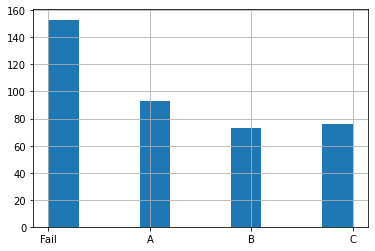

In [5]:
# Sort Grade 3 results into A,B,C and Fail Grades
# A >= 70%
# B >= 60%
# C >= 50%
# Fail < 70%

def bin_grades(dataset):
  dataset['final_grade'] = pd.cut(dataset['avg_grade'],
                            bins=[-np.inf, 9.0, 11.0, 13.0, 20],
                            labels=['Fail', 'C', 'B', 'A'])
  
bin_grades(students)
students['final_grade'].hist()

## Data Subsets

In order to find relationships between the features of our data we will split the data into smaller datasets.

activities_data - This dataset will contain infortmation relating to a students extra-cirricular activities

family_data - This dataset will contain information relating to a students family life.

school_data - This dataset will contain information relating to a students school and study habits.

personal_data - This dataset contains information relating to the invdividuals lifestyle and health

Removing the G1, G2, G3 and average grade to see the influence of other factors.

In [6]:
activities_data = students[['activities','romantic','freetime','goout','Dalc','Walc','final_grade']]
family_data = students[['famsize','Pstatus','Medu','Fedu','Mjob','Fjob','guardian','famsup','internet','final_grade']]
school_data = students[['school','studytime','failures','schoolsup','paid','nursery','higher','absences','G1','G2','G3','final_grade']]
personal_data = students[['school','sex','age','Dalc','Walc','health','absences','final_grade']]

subsets = [activities_data, family_data, school_data, personal_data]

## Training and Test Data

Split into training and test sets using following function

In [7]:
# Can also do stratified data split
from sklearn.model_selection import StratifiedShuffleSplit

def split_dataset(data, ratio):
  split = StratifiedShuffleSplit(n_splits=1, test_size=ratio, random_state=42)
  for train_index, test_index in split.split(data, data["final_grade"]):
      strat_train_set = data.loc[train_index]
      strat_test_set = data.loc[test_index]
  return strat_train_set, strat_test_set

For the current lab we want to look at the outside activity of the students to see if it can be linearly seperated. We will do a 80/20 split on training/test.

In [8]:
activities_train , activities_test = split_dataset(activities_data, 0.2)

In [9]:
activities_train

,activities,romantic,freetime,goout,Dalc,Walc,final_grade
340,yes,yes,3,4,1,3,C
219,yes,no,3,3,1,1,C
115,yes,no,4,4,1,2,A
206,no,no,3,3,2,2,Fail
46,no,no,3,5,1,4,C
...,...,...,...,...,...,...,...
337,no,yes,3,2,2,3,Fail
196,no,no,2,3,1,2,A
80,yes,yes,2,2,1,3,C
227,no,no,3,3,1,3,B


## Preprocessing

In [10]:
# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

def get_types(dataset):
  num_attr = list(dataset.select_dtypes(include='number'))
  cat_attr = list(dataset.select_dtypes(exclude='number'))
  print(num_attr, cat_attr)
  return num_attr, cat_attr

num, cat = get_types(activities_train)

num_pipeline = Pipeline([
      ('MnMx_scaler', MinMaxScaler()),
  ])
cat_pipeline = OrdinalEncoder()

full_pipeline =  ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num),#  Apply the numerical transformation to the all numeric columns
        ("cat", cat_pipeline, cat), # Apply the One Hot Encoding to the all categorical columns
  ])

['freetime', 'goout', 'Dalc', 'Walc'] ['activities', 'romantic', 'final_grade']


In [15]:
activities_prep = full_pipeline.fit_transform(activities_train)
activities_test_prep = full_pipeline.fit_transform(activities_test)

In [12]:
activities_train.head(3)

,activities,romantic,freetime,goout,Dalc,Walc,final_grade
340,yes,yes,3,4,1,3,C
219,yes,no,3,3,1,1,C
115,yes,no,4,4,1,2,A


In [13]:
activities_prep[0]

array([0.5 , 0.75, 0.  , 0.5 , 1.  , 1.  , 2.  ])

Remove the final column which correlates to final_grade

In [16]:
activities_target = activities_prep[:,6]
activities_prep = np.delete(activities_prep, np.s_[6:], 1)
activities_test_target = activities_test_prep[:,6]
activities_test_prep = np.delete(activities_test_prep, np.s_[6:], 1)

# Linear Regression

Get the intial weights from the fitted function.

freetime = -0.27
goout = 0.33
Dalc = 0.36
Walc = 0.36
Activities = -0.028
Romance = 0.18

In [17]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(activities_prep, activities_target)
lin_reg.intercept_ , lin_reg.coef_

(1.4952067372431035,
 array([-0.26687659,  0.33244866,  0.36138528,  0.36074293, -0.02773501,
         0.18219818]))

In [ ]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(activities_prep, activities_target, rcond=1e-6)
theta_best_svd # Least-squares solution

array([1.02486977, 1.0621946 , 0.10395427, 0.59496887, 0.17382119,
       0.40445947])

It can be shown that excluding the grade scores student attain through the year obtains a small score from the linear regression. When given new data in the form of a test set, the score falls more. This suggests that the function does not generalise to new data very well. This could imply that the features that are being measured for do not infact have influence over the target feature.

The suggestion is that the activities that a student partakes in outside of their school environment does not influence the final grade that they would achieve.

In [18]:
lin_reg.score(activities_prep, activities_target)

0.04048300721326381

In [19]:
lin_reg.score(activities_test_prep, activities_test_target)

-0.013670201474999422

In [20]:
eta = 0.1
n_iterations = 1000
m = 100

theta = np.random.randn(6,1) 

for iteration in range(n_iterations):
    gradients = 2/m * activities_prep.T.dot(activities_prep.dot(theta) - activities_target)

In [21]:
theta

array([[-0.20800238],
       [ 0.05456341],
       [-0.70576596],
       [-1.51014981],
       [-1.60786655],
       [ 0.44749753]])

In [28]:

theta_path_bgd = []
def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(activities_prep)
    plt.plot(activities_prep, activities_target, "b.")
    n_iterations = 100
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = activities_prep.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(activities_prep, y_predict ,style)
        gradients = 2/m * activities_prep.T.dot(activities_prep.dot(theta) - activities_target)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: cycling among columns

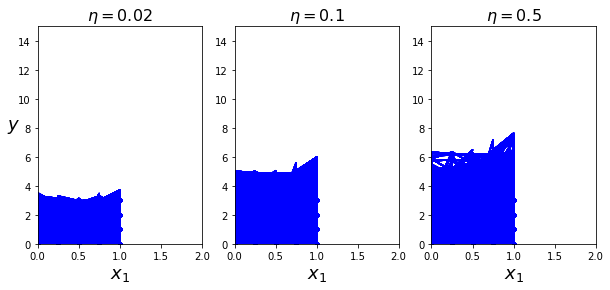

In [29]:
np.random.seed(42)
theta = np.random.randn(6,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

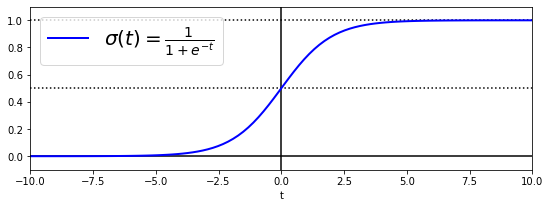

In [ ]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(activities_prep, activities_target)

LogisticRegression(random_state=42)

In [ ]:
y_proba = log_reg.predict_proba(activities_prep)

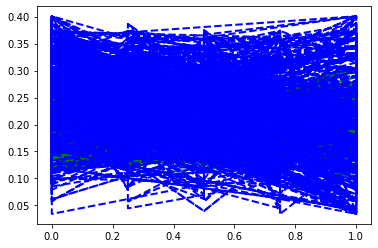

In [ ]:
plt.plot(activities_prep, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(activities_prep, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

ValueError: x and y can be no greater than 2D, but have shapes (2, 0, 6) and (2,)

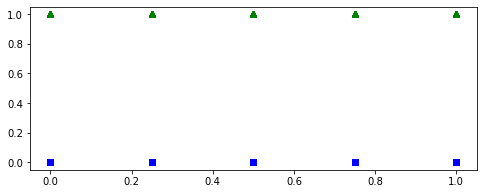

In [ ]:
decision_boundary = activities_prep[y_proba[:, 1] >= 0.5]

plt.figure(figsize=(8, 3))
plt.plot(activities_prep[activities_target==0], activities_target[activities_target==0], "bs")
plt.plot(activities_prep[activities_target==1], activities_target[activities_target==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(activities_prep, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(activities_prep, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

In [ ]:
decision_boundary

array([], shape=(0, 6), dtype=float64)

In [ ]:
log_reg.predict([[1.7], [1.5]])

ValueError: X has 1 features, but LogisticRegression is expecting 6 features as input.

In [ ]:
from sklearn.linear_model import LogisticRegression

X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()